In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import histogram, cumulative_distribution
from scipy.stats import cauchy, logistic

In [20]:
# image = cv2.imread("data/2135041001/front.jpg")
image = cv2.imread("data/2135041167/front.jpg")
# image = cv2.imread("data/2135041006/front.jpg")
# image = cv2.imread("data/2135041007/front.jpg")
# image = cv2.imread("data/2135041040/front.jpg") 
# image = cv2.imread("data/2135041043/front.jpg") # edges got blended into cases
# image = cv2.imread("data/2135041048/front.jpg") # edges got blended into cases
# image = cv2.imread("data/2135041054/front.jpg")
# image = cv2.imread("data/3718372019/front.jpg")
# image = cv2.imread("data/3734194001/front.jpg")
# image = cv2.imread("data/3761772053/front.jpg") # edges got blended into cases
# image = cv2.imread("data/3788404014/front.jpg")
# image = cv2.imread("data/3798764016/front.jpg") # not found
# image = cv2.imread("data/3821556106/front.jpg") # edges got blended into cases
# image = cv2.imread("data/3824670033/front.jpg") # edges got blended into cases
# image = cv2.imread("data/3838512098/front.jpg") # not found
# image = cv2.imread("data/3865838027/front.jpg") # not found
# image = cv2.imread("data/3871141001/front.jpg") # edges got blended into cases
# image = cv2.imread("data/3836849030/front.jpg") # edges got blended into cases
#workflow

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# to grayscale image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# get edges
blur = cv2.GaussianBlur(gray, (3, 3), -10)
adaptive_binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7,3)
edges = cv2.Canny(adaptive_binary,100,200)
binarized_grad = 255 - edges

# denoises again
open_binarized_grad = cv2.morphologyEx(
    binarized_grad, 
    cv2.MORPH_OPEN, 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))

# get contours
contours, _ = cv2.findContours(open_binarized_grad, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# image size
height, width = binarized_grad.shape
image_area = height * width

# sort contour index
index_sort = sorted(range(len(contours)), key=lambda i : cv2.contourArea(contours[i]),reverse=True)
contours_sort = [contours[i] for i in index_sort]

# get area and perimeter
contour_area = [cv2.contourArea(contours_sort[i]) for i in range(len(index_sort))]
contour_peri = [cv2.arcLength(contours_sort[i], True) for i in range(len(index_sort))]
approx = [cv2.approxPolyDP(contours_sort[i], 0.001 * contour_peri[i], True) for i in range(len(index_sort))]
bounding_box = [cv2.boundingRect(approx[i]) for i in range(len(index_sort))]
is_card = list(filter(lambda x : x >= 0, [i if contour_area[i] >= 0.48 * image_area and contour_area[i] <= 0.6 * image_area else -1 for i in range(len(index_sort))]))

is_card_index = is_card[-1]
card_bounding_box = bounding_box[is_card_index]

final = cv2.rectangle(
    image.copy(), 
    (int(card_bounding_box[0]), int(card_bounding_box[1])),
    (int(card_bounding_box[0] + card_bounding_box[2]), int(card_bounding_box[1] + card_bounding_box[3])), 
    (0,255,0), 3
)

IndexError: list index out of range

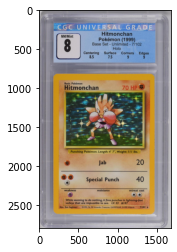

In [21]:
plt.imshow(image)

In [ ]:
# convert to gray and increase intensity
plt.imshow(gray, cmap = 'gray')

In [ ]:
plt.imshow(binarized_grad, cmap = 'gray')

In [ ]:
plt.imshow(open_binarized_grad, cmap = 'gray')

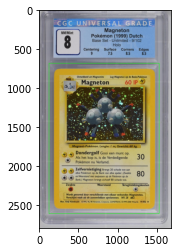

In [10]:
plt.imshow(final)

In [3]:
def test_contour(image : np.ndarray):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # to grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # get edges
    blur = cv2.GaussianBlur(gray, (3, 3), -10)
    adaptive_binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7,3)
    edges = cv2.Canny(adaptive_binary,100,200)
    binarized_grad = 255 - edges

    # denoises again
    open_binarized_grad = cv2.morphologyEx(
        binarized_grad, 
        cv2.MORPH_OPEN, 
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))

    # get contours
    contours, _ = cv2.findContours(open_binarized_grad, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # image size
    height, width = binarized_grad.shape
    image_area = height * width

    # sort contour index
    index_sort = sorted(range(len(contours)), key=lambda i : cv2.contourArea(contours[i]),reverse=True)
    contours_sort = [contours[i] for i in index_sort]

    # get area and perimeter
    contour_area = [cv2.contourArea(contours_sort[i]) for i in range(len(index_sort))]
    contour_peri = [cv2.arcLength(contours_sort[i], True) for i in range(len(index_sort))]
    approx = [cv2.approxPolyDP(contours_sort[i], 0.001 * contour_peri[i], True) for i in range(len(index_sort))]
    bounding_box = [cv2.boundingRect(approx[i]) for i in range(len(index_sort))]
    is_card = list(filter(lambda x : x >= 0, [i if contour_area[i] >= 0.48 * image_area and contour_area[i] <= 0.7 * image_area else -1 for i in range(len(index_sort))]))

    return len(is_card) > 0

In [4]:
import glob
import os
total_number_of_images = 0
contour_found = 0
for file_path in glob.glob(os.path.join('data','*')):
    image_file_path = os.path.join(file_path, "front.jpg")
    try:
        image = cv2.imread(image_file_path)
        if test_contour(image):
            contour_found += 1
        total_number_of_images += 1
    except:
        pass

In [5]:
print(f"Current images whose content found: {contour_found}")
print(f"Current processed images: {total_number_of_images}")

Current images whose content found: 6929
Current processed images: 8214
